In [2]:
import os
import re
import collections
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from regressors import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn import preprocessing
from sklearn.feature_selection import RFECV 
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import warnings
warnings.filterwarnings('ignore')

<font size =5>(a) Download the AReM data from: https://archive.ics.uci.edu/ml/datasets/

<font size = 5>(b) Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.

In [11]:
colnames = ['time', 'avg_rss12', 'var_rss12', 'avg_rss13','var_rss13', 'avg_rss23', 'var_rss23']
path = "AReM" 
folders= os.listdir(path)

# train_data = []
# test_data = []
data_dict = {}


for folder in folders:
    files = os.listdir(path+"/"+folder)
    for file in files:
        print(file)
        if file == 'dataset4.csv' and folder  == 'bending2':
            data = pd.read_csv(path+"/"+ folder + '/' + file, sep=' ', skiprows = 5 ,names = colnames, usecols = range(7))
        else:
            data = pd.read_csv(path+"/"+ folder + '/' + file, sep=',', skiprows = 5 ,names = colnames, usecols = range(7))
            
        if 'bending' in folder:
            data['activity'] = 1
        else:
            data['activity'] = 0

        if folder not in data:
            data_dict[folder] = [data]
        else:
            data_dict[folder].append(data)
    
train_data = data_dict['bending1'][2:7] + data_dict['bending2'][2:6] + data_dict['cycling'][3:15] + \
        data_dict['lying'][3:15] + data_dict['sitting'][3:15] + data_dict['standing'][3:15] + \
        data_dict['walking'][3:15]
test_data = data_dict['bending1'][0:2] + data_dict['bending2'][0:2] + data_dict['cycling'][0:3] + \
       data_dict['lying'][0:3] + data_dict['sitting'][0:3] + data_dict['standing'][0:3] + \
       data_dict['walking'][0:3]
    
                
print('Test data set count: \n' , len(test_data) , '\n')
print(test_data)
print('/////////////////////////////////////////////////////////////////////////////////')
print('Train data set count: \n' , len(train_data))
print(train_data)
        

dataset7.csv
dataset6.csv
dataset4.csv
dataset5.csv
dataset1.csv
dataset2.csv
dataset3.csv
dataset7.csv
dataset6.csv
dataset4.csv
dataset5.csv
dataset1.csv
dataset2.csv
dataset3.csv
dataset10.csv
dataset11.csv
dataset13.csv
dataset12.csv
dataset15.csv
dataset14.csv
dataset8.csv
dataset9.csv
dataset6.csv
dataset4.csv
dataset5.csv
dataset1.csv
dataset2.csv
dataset3.csv
dataset7.csv
dataset6.csv
dataset4.csv
dataset5.csv
dataset1.csv
dataset2.csv
dataset3.csv
dataset10.csv
dataset11.csv
dataset13.csv
dataset12.csv
dataset15.csv
dataset14.csv
dataset8.csv
dataset9.csv
dataset7.csv
dataset6.csv
dataset4.csv
dataset5.csv
dataset1.csv
dataset2.csv
dataset3.csv
dataset10.csv
dataset11.csv
dataset13.csv
dataset12.csv
dataset15.csv
dataset14.csv
dataset8.csv
dataset9.csv
dataset7.csv
dataset6.csv
dataset4.csv
dataset5.csv
dataset1.csv
dataset2.csv
dataset3.csv
dataset10.csv
dataset11.csv
dataset13.csv
dataset12.csv
dataset15.csv
dataset14.csv
dataset8.csv
dataset9.csv
dataset7.csv
dataset6.csv
d

<font size = 5>(c) Feature Extraction
Classification of time series usually needs extracting features from them. In this problem, we focus on time-domain features.
    
i. Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).

# Ans: Means, Standard deviations, Skewness, Kurtosis, Maximum, Minimum values and Variance
https://www.quora.com/How-can-I-extract-the-features-from-time-series 

https://stats.stackexchange.com/questions/50807/features-for-time-series-classification

<font size=5>ii. Extract the time-domain features minimum, maximum, mean, median, stan- dard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly.

In [142]:
feature_dict_list = []
i= 0
for folder in folders:
    files = os.listdir(path+"/"+folder)
    for file in files:
        data = pd.read_csv(path+"/"+ folder + '/' + file, 
                           sep= ' ' if file == 'dataset4.csv' and folder  == 'bending2' else ',',
                           skiprows = 5 ,names = colnames, usecols = range(7))
        feature_dict_list.append({'0file': folder + '/' + file})
        for column in range(1,7):
            minimum = {'min_' + f'{column}' :data.iloc[:,column].to_frame().min()[0]}
            maximum = {'max_' + f'{column}' :data.iloc[:,column].to_frame().max()[0]}
            mean = {'mean_' + f'{column}' :data.iloc[:,column].to_frame().mean()[0]}
            median = {'median_' + f'{column}' :data.iloc[:,column].to_frame().median()[0]}
            std = {'std_' + f'{column}' :data.iloc[:,column].to_frame().std()[0]}
            quartile_1 = {'1st Quart_' + f'{column}' :data.iloc[:,column].to_frame().quantile(.25, axis = 0)[0]}
            quartile_3 = {'3st Quart_' + f'{column}' :data.iloc[:,column].to_frame().quantile(.75, axis = 0)[0]}
            feature_dict_list[i].update(minimum)
            feature_dict_list[i].update(maximum)
            feature_dict_list[i].update(mean)
            feature_dict_list[i].update(median)
            feature_dict_list[i].update(std)
            feature_dict_list[i].update(quartile_1)
            feature_dict_list[i].update(quartile_3)
        ## Add col type to seperate train an test data
        if ('bending' in folder and int(''.join(re.findall("\d+",file))) <= 2) or \
        ('bending' not in folder and int(''.join(re.findall("\d+",file))) <= 3):
            set_type = {'type':'test'}
            feature_dict_list[i].update(set_type)
        else:
            set_type = {'type':'train'}
            feature_dict_list[i].update(set_type)
            
        i += 1
feature_dict_set = pd.DataFrame(feature_dict_list)
feature_dict_set
# pd.DataFrame.from_dict(feature_dict_list)


,0file,1st Quart_1,1st Quart_2,1st Quart_3,1st Quart_4,1st Quart_5,1st Quart_6,3st Quart_1,3st Quart_2,3st Quart_3,...,min_4,min_5,min_6,std_1,std_2,std_3,std_4,std_5,std_6,type
0,bending1/dataset7.csv,43.3100,0.4300,14.2500,0.0000,20.5000,0.0000,44.6700,0.5000,18.0000,...,0.0,11.33,0.00,1.618364,0.263111,3.742420,0.788985,3.318301,0.487826,train
1,bending1/dataset6.csv,42.5000,0.0000,13.0000,0.4300,22.2500,0.4300,45.0000,0.5000,18.2700,...,0.0,8.00,0.00,1.386098,0.315566,3.847638,0.995761,2.488862,0.622534,train
2,bending1/dataset4.csv,39.1500,0.0000,20.5000,0.4300,30.4575,0.0000,45.0000,1.1200,24.3725,...,0.0,20.00,0.00,3.670666,0.630860,3.810469,0.953730,3.849448,0.524317,train
3,bending1/dataset5.csv,41.3300,0.4300,16.5000,0.4300,28.4575,0.0000,42.7500,0.7100,22.0625,...,0.0,23.67,0.00,2.243490,0.405469,4.087107,0.928801,2.411026,0.389164,train
4,bending1/dataset1.csv,39.2500,0.0000,16.0000,0.0000,33.0000,0.0000,42.0000,0.5000,23.2500,...,0.0,27.25,0.00,1.476967,0.322605,4.462952,0.965659,2.188449,0.582915,test
5,bending1/dataset2.csv,42.0000,0.0000,19.0000,0.0000,32.0000,0.0000,43.6700,0.5000,22.2500,...,0.0,27.67,0.00,1.435550,0.289158,3.893737,1.047259,1.995255,0.601010,test
6,bending1/dataset3.csv,43.0000,0.0000,19.7500,0.0000,35.3625,0.0000,45.0000,0.5000,24.0000,...,0.0,29.00,0.00,1.558835,0.338690,3.030943,0.550657,1.999604,0.513506,train
7,walking/dataset7.csv,31.2500,2.4900,13.6700,2.0500,13.7500,2.0500,38.0000,5.7450,17.5000,...,0.0,6.67,0.00,4.948770,2.568680,2.967741,1.676271,3.000493,1.617290,train
8,walking/dataset6.csv,32.0000,2.3500,13.3300,2.0575,14.2375,2.1200,38.0625,5.6250,17.6700,...,0.0,6.33,0.00,4.645944,2.335243,2.900248,1.503446,3.192058,1.700918,train
9,walking/dataset4.csv,32.0000,2.4800,13.3300,1.9125,14.2500,1.8850,38.7500,5.8700,17.5000,...,0.0,6.25,0.00,4.751868,2.625516,3.114222,1.508714,3.207642,1.769182,train


<font size = 5>iii. Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.

In [134]:
std_feature_dict = feature_dict_set.std()
std_feature_set = std_feature_dict.to_frame()
std_feature_set.columns = ['Standard Deviation']

for i in range(0, std_feature_set.shape[0]):
    feature_single_col = np.array(feature_dict_set.loc[:,std_feature_set.index[0]])
    feature_bs = bs.bootstrap(feature_single_col, bs_stats.std, alpha = 0.10)
    std_feature_set.loc[std_feature_set.index[i],'Bootstrapped STD and Confidence Interval'] = feature_bs
    
pd.set_option('display.max_colwidth', -1 )
std_feature_set

,Standard Deviation,Bootstrapped STD and Confidence Interval
1st Quart_1,6.153590,"6.118526249454473 (5.638737914050403, 6.698226472131168)"
1st Quart_2,0.946386,"6.118526249454473 (5.636982376743666, 6.702650488875862)"
1st Quart_3,4.220658,"6.118526249454473 (5.631357584206455, 6.691023538755573)"
1st Quart_4,0.843620,"6.118526249454473 (5.62676815720377, 6.6956195057550625)"
1st Quart_5,6.096465,"6.118526249454473 (5.6380930119589605, 6.70417691794456)"
1st Quart_6,0.758584,"6.118526249454473 (5.622754819103988, 6.686673435116274)"
3st Quart_1,5.138925,"6.118526249454473 (5.632984586062942, 6.696067014759694)"
3st Quart_2,2.125266,"6.118526249454473 (5.634643498294089, 6.693832320080909)"
3st Quart_3,4.171628,"6.118526249454473 (5.623155027750809, 6.687148204178977)"
3st Quart_4,1.552504,"6.118526249454473 (5.629978289321309, 6.703049649768605)"


<font size = 5>iv. Use your judgement to select the three most important time-domain features (one option may be min, mean, and max).

# I will select min, mean and max as three most important features

<font size = 5> (d) Binary Classification Using Logistic Regression3
i. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities.

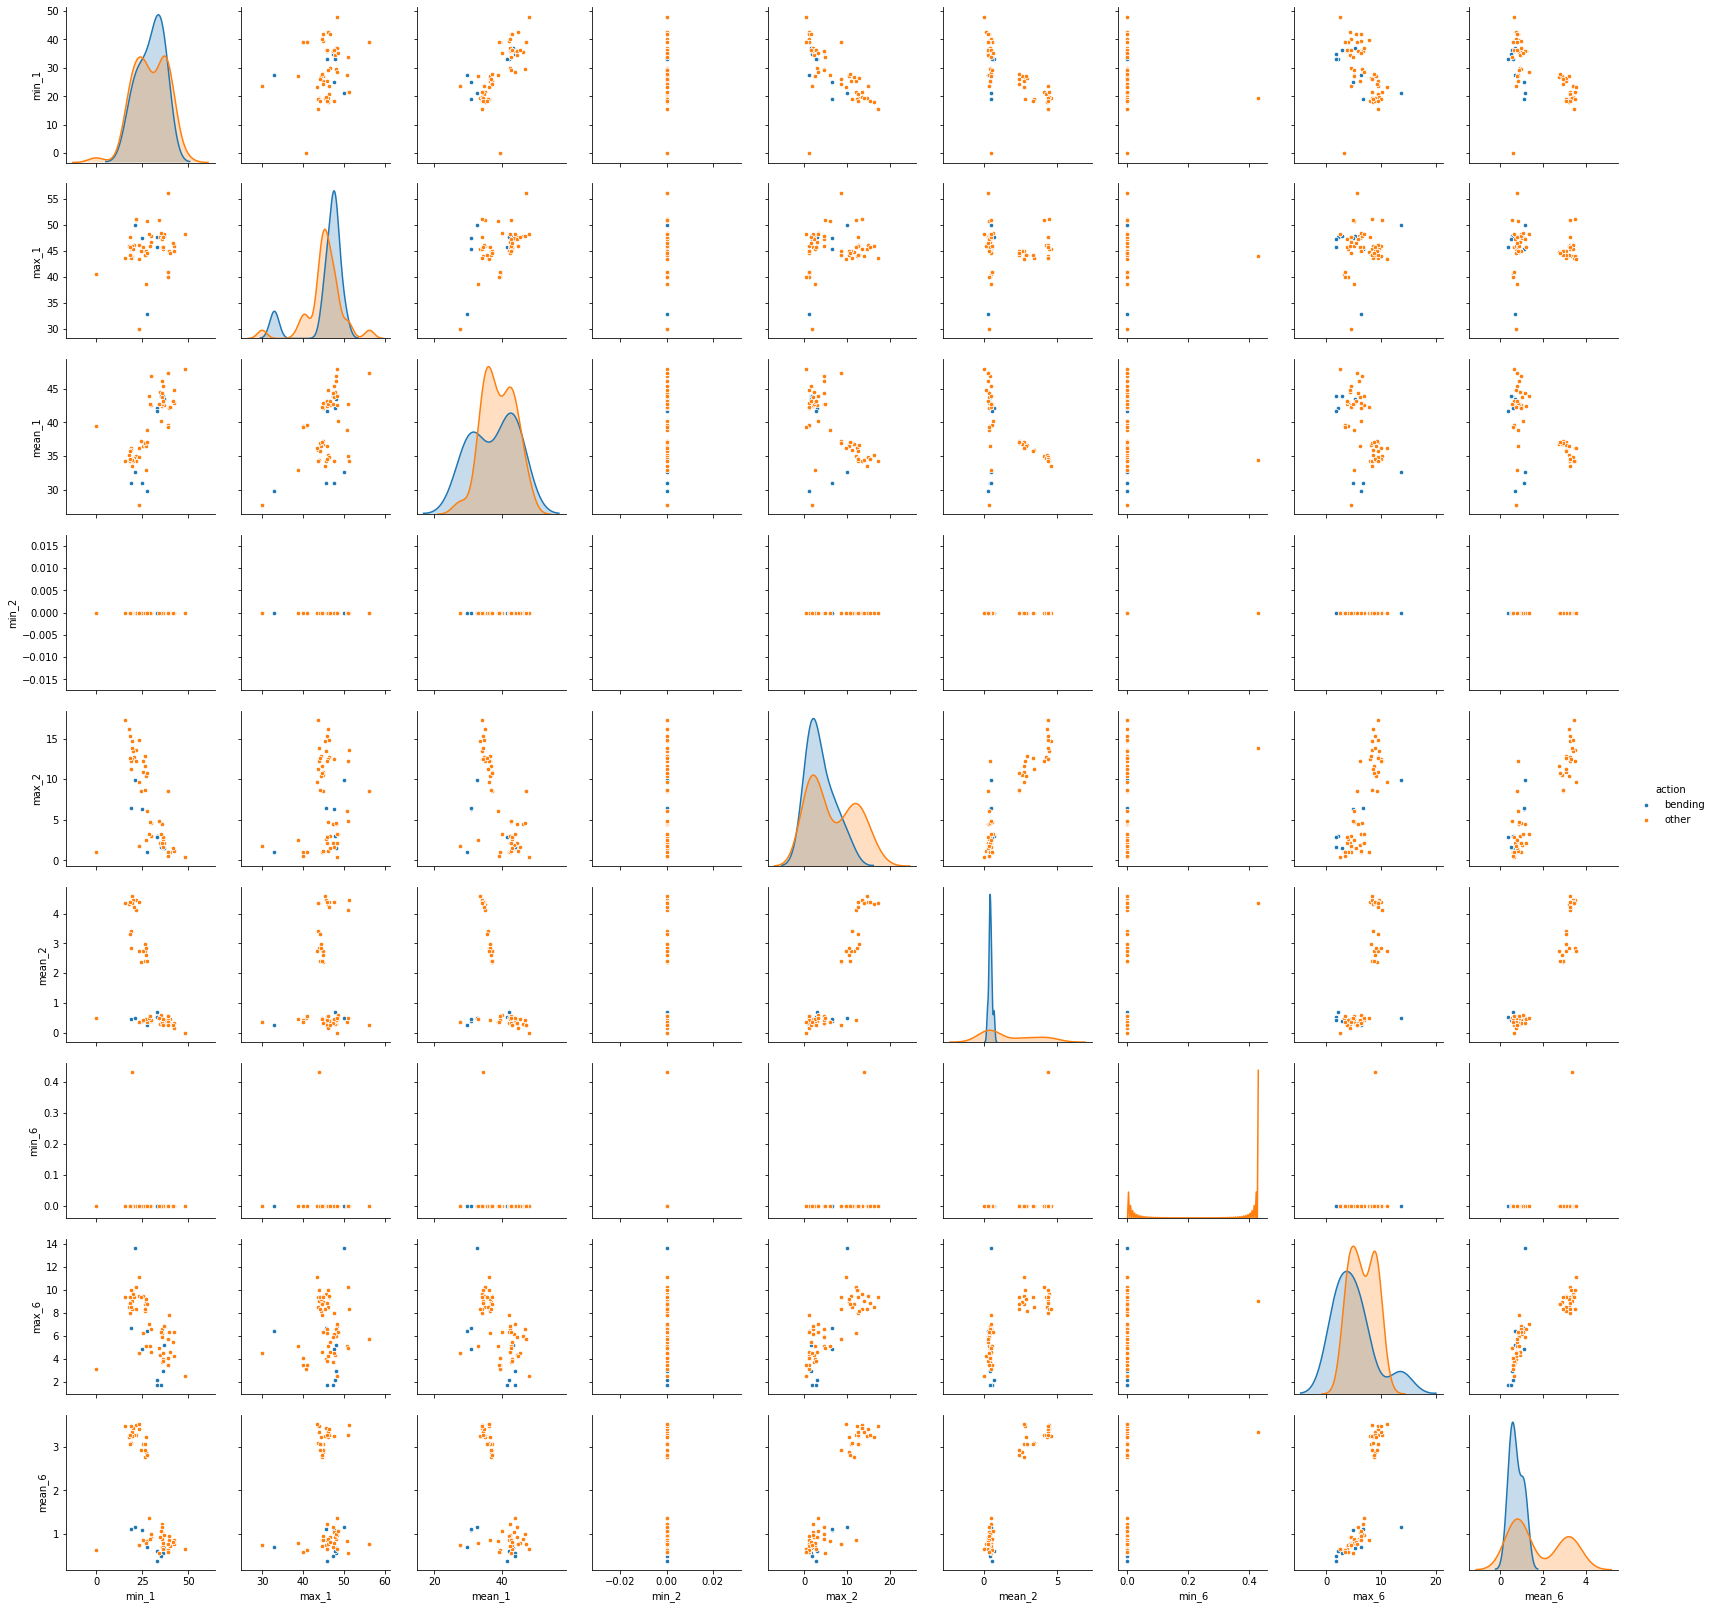

In [160]:
ext_feature_set =  feature_dict_set.where(feature_dict_set['type'] == 'train').dropna().loc \
[:, ['0file','min_1', 'max_1', 'mean_1', 'min_2', 'max_2', 'mean_2','min_6', 'max_6', 'mean_6']]
ext_feature_set['action'] = ext_feature_set['0file'].apply(lambda x: 'bending' if 'bending' in x else 'other')
sns.pairplot(ext_feature_set, hue = "action", plot_kws=dict(s=20))
# ext_feature_set.where(ext_feature_set['action'] == 'bending').dropna()

<font size = 5> ii. Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 1(d)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 12. Do you see any considerable difference in the results with those of 1(d)i?

In [183]:
feature_dict_list2 = []
i= 0
for folder in folders:
    files = os.listdir(path+"/"+folder)
    for file in files:
        data = pd.read_csv(path+"/"+ folder + '/' + file, 
                           sep= ' ' if file == 'dataset4.csv' and folder  == 'bending2' else ',',
                           skiprows = 5 ,names = colnames, usecols = range(7))
        feature_dict_list2.append({'0file': folder + '/' + file})
        for column in range(1,7):
            minimum = {'min_' + f'{column}' :data.iloc[:int(data.shape[0]/2),column].to_frame().min()[0]}
            maximum = {'max_' + f'{column}' :data.iloc[:int(data.shape[0]/2),column].to_frame().max()[0]}
            mean = {'mean_' + f'{column}' :data.iloc[:int(data.shape[0]/2),column].to_frame().mean()[0]}
            median = {'median_' + f'{column}' :data.iloc[:int(data.shape[0]/2),column].to_frame().median()[0]}
            std = {'std_' + f'{column}' :data.iloc[:int(data.shape[0]/2),column].to_frame().std()[0]}
            quartile_1 = {'1st Quart_' + f'{column}' :data.iloc[:int(data.shape[0]/2),column].to_frame().quantile(.25, axis = 0)[0]}
            quartile_3 = {'3st Quart_' + f'{column}' :data.iloc[:int(data.shape[0]/2),column].to_frame().quantile(.75, axis = 0)[0]}
            feature_dict_list2[i].update(minimum)
            feature_dict_list2[i].update(maximum)
            feature_dict_list2[i].update(mean)
            feature_dict_list2[i].update(median)
            feature_dict_list2[i].update(std)
            feature_dict_list2[i].update(quartile_1)
            feature_dict_list2[i].update(quartile_3)
            
            minimum_ = {'min_' + f'{column+6}' :data.iloc[data.shape[0]-int(data.shape[0]/2):,column].to_frame().min()[0]}
            maximum_ = {'max_' + f'{column+6}' :data.iloc[data.shape[0]-int(data.shape[0]/2):,column].to_frame().max()[0]}
            mean_ = {'mean_' + f'{column+6}' :data.iloc[data.shape[0]-int(data.shape[0]/2):,column].to_frame().mean()[0]}
            median_ = {'median_' + f'{column+6}' :data.iloc[data.shape[0]-int(data.shape[0]/2):,column].to_frame().median()[0]}
            std_ = {'std_' + f'{column+6}' :data.iloc[data.shape[0]-int(data.shape[0]/2):,column].to_frame().std()[0]}
            quartile_1_ = {'1st Quart_' + f'{column+6}' :data.iloc[data.shape[0]-int(data.shape[0]/2):,column].to_frame().quantile(.25, axis = 0)[0]}
            quartile_3_ = {'3st Quart_' + f'{column+6}' :data.iloc[data.shape[0]-int(data.shape[0]/2):,column].to_frame().quantile(.75, axis = 0)[0]}
            feature_dict_list2[i].update(minimum_)
            feature_dict_list2[i].update(maximum_)
            feature_dict_list2[i].update(mean_)
            feature_dict_list2[i].update(median_)
            feature_dict_list2[i].update(std_)
            feature_dict_list2[i].update(quartile_1_)
            feature_dict_list2[i].update(quartile_3_)
        ## Add col type to seperate train an test data
        if ('bending' in folder and int(''.join(re.findall("\d+",file))) <= 2) or \
        ('bending' not in folder and int(''.join(re.findall("\d+",file))) <= 3):
            set_type = {'type':'test'}
            feature_dict_list2[i].update(set_type)
        else:
            set_type = {'type':'train'}
            feature_dict_list2[i].update(set_type)
            
        i += 1
feature_dict_set2 = pd.DataFrame(feature_dict_list2)
# feature_dict_set2

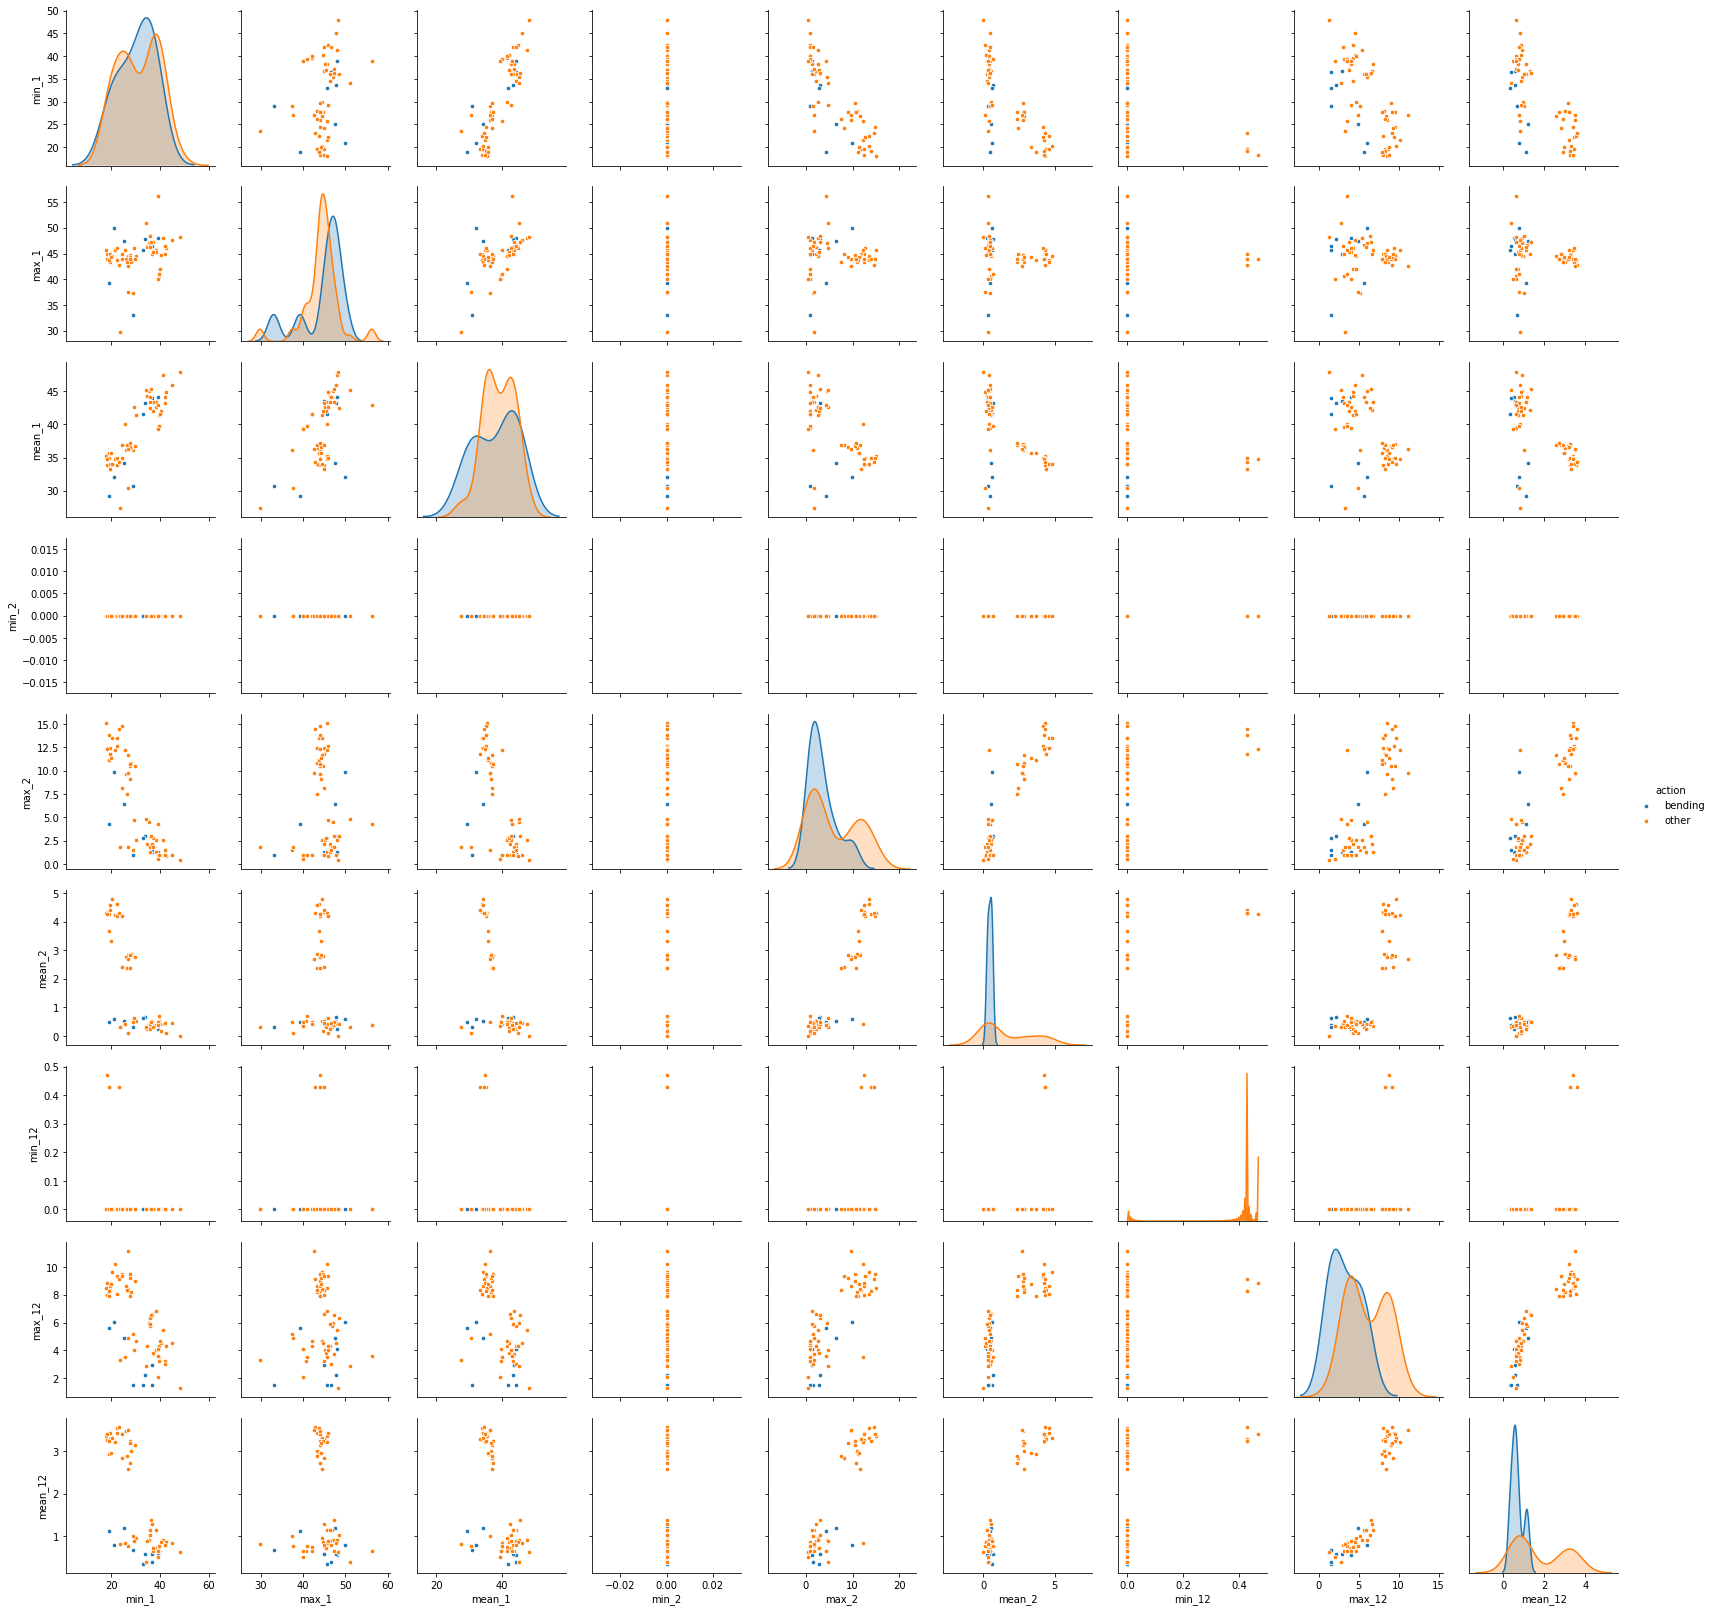

In [182]:
ext_feature_set2 =  feature_dict_set2.where(feature_dict_set2['type'] == 'train').dropna().loc \
[:, ['0file','min_1', 'max_1', 'mean_1', 'min_2', 'max_2', 'mean_2','min_12', 'max_12', 'mean_12']]
ext_feature_set2['action'] = ext_feature_set2['0file'].apply(lambda x: 'bending' if 'bending' in x else 'other')
sns.pairplot(ext_feature_set2, hue = "action", plot_kws=dict(s=20))

# Ans: I think these two results are similar

<font size =5>iii. Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and use logistic regression5 to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance. Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l and refit a logistic regression model using your pruned set of features.6 Alternatively, you can use backward selection using sklearn.feature selection or glm in R. Use 5-fold cross-validation to determine the best value of the pair (l, p), where p is the number of features used in recursive feature elimination. Explain what the right way and the wrong way are to perform cross-validation in this problem.

In [305]:
report_dict_list = []
length = list(range(1,21))
# count = 0

for l in length:
    train_dict_list = []
    j = 0
    print(l)
    for data in train_data:
            row = int(data.shape[0] / l)
            train_dict_list.append({'action': 1 if 'bending' in data.iloc[0]['action'] else 0})
            x = 0
            for i in range(0,l):
                sliced_data = data.iloc[i*row: (i+1)*row]
                k = 0
                
                for column in range(1,7):
#                     minimum = {'min_' + f'{k*7+column}' :sliced_data.iloc[:,column].to_frame().min()[0]}
#                     maximum = {'max_' + f'{k*7+column}' :sliced_data.iloc[:,column].to_frame().max()[0]}
#                     mean = {'mean_' + f'{k*7+column}' :sliced_data.iloc[:,column].to_frame().mean()[0]}
#                     median = {'median_' + f'{k*7+column}' :sliced_data.iloc[:,column].to_frame().median()[0]}
#                     std = {'std_' + f'{k*7+column}' :sliced_data.iloc[:,column].to_frame().std()[0]}
#                     quartile_1 = {'1st Quart_' + f'{k*7+column}' :sliced_data.iloc[:,column].to_frame().quantile(.25, axis = 0)[0]}
#                     quartile_3 = {'3st Quart_' + f'{k*7+column}' :sliced_data.iloc[:,column].to_frame().quantile(.75, axis = 0)[0]}
                    minimum = {x :sliced_data.iloc[:,column].to_frame().min()[0]}
                    x+=1
                    maximum = {x :sliced_data.iloc[:,column].to_frame().max()[0]}
                    x+=1
                    mean = {x :sliced_data.iloc[:,column].to_frame().mean()[0]}
                    x+=1
                    median = {x :sliced_data.iloc[:,column].to_frame().median()[0]}
                    x+=1
                    std = {x :sliced_data.iloc[:,column].to_frame().std()[0]}
                    x+=1
                    quartile_1 = {x:sliced_data.iloc[:,column].to_frame().quantile(.25, axis = 0)[0]}
                    x+=1
                    quartile_3 = {x:sliced_data.iloc[:,column].to_frame().quantile(.75, axis = 0)[0]}
                    x+=1
    
                    train_dict_list[j].update(minimum)
                    train_dict_list[j].update(maximum)
                    train_dict_list[j].update(mean)
                    train_dict_list[j].update(median)
                    train_dict_list[j].update(std)
                    train_dict_list[j].update(quartile_1)
                    train_dict_list[j].update(quartile_3)
                    k=k+1
#             train_dict_list[j] = collections.OrderedDict(sorted(train_dict_list[j].items()))   
#             train_dict_list[j].update({'action': 1 if 'bending' in data.iloc[0]['action'] else 0})
            j = j+1
            
            
    train_slided_data = pd.DataFrame.from_dict(train_dict_list)
#     print(train_slided_data)
    
    x_train = train_slided_data.iloc[:,1:]
#     print(x_train)
    y_train = train_slided_data[['action']]
#     print(y_train)

    lrg = LogisticRegression()
    rfecv = RFECV(estimator = lrg, cv = StratifiedKFold(5))
    rfecv.fit(x_train, y_train.values)
    
    report_dict_list.append({'Number of Time Series <l>':l,'Number of Features <p>':rfecv.n_features_,'Cross Validation Score':max(rfecv.grid_scores_)})
#     print(report_dict_list)
pd.DataFrame.from_dict(report_dict_list)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


,Cross Validation Score,Number of Features <p>,Number of Time Series <l>
0,0.957143,9,1
1,0.957143,6,2
2,0.957143,2,3
3,0.957143,4,4
4,0.957143,4,5
5,0.942857,2,6
6,0.956044,4,7
7,0.957143,4,8
8,0.957143,4,9
9,0.957143,7,10


<font size = 5> iv.Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.

Confusion Matrix:


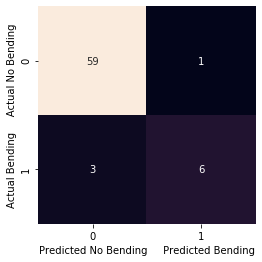


The ROC Curve when l = 1 is as follows graph, and the AUC = 0.82


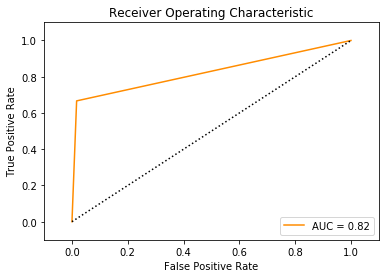

In [312]:
l = 18
report_dict_list = []
train_dict_list = []
j = 0

for data in train_data:
        row = int(data.shape[0] / l)
        train_dict_list.append({'0action': 1 if 'bending' in data.iloc[0]['action'] else 0})
        for i in range(0,l):
            sliced_data = data.iloc[i*row: (i+1)*row]
            k=0

            for column in range(1,7):
                minimum = {'min_' + f'{k*7+column}' :sliced_data.iloc[:,column].to_frame().min()[0]}
                maximum = {'max_' + f'{k*7+column}' :sliced_data.iloc[:,column].to_frame().max()[0]}
                mean = {'mean_' + f'{k*7+column}' :sliced_data.iloc[:,column].to_frame().mean()[0]}
                median = {'median_' + f'{k*7+column}' :sliced_data.iloc[:,column].to_frame().median()[0]}
                std = {'std_' + f'{k*7+column}' :sliced_data.iloc[:,column].to_frame().std()[0]}
                quartile_1 = {'1st Quart_' + f'{k*7+column}' :sliced_data.iloc[:,column].to_frame().quantile(.25, axis = 0)[0]}
                quartile_3 = {'3st Quart_' + f'{k*7+column}' :sliced_data.iloc[:,column].to_frame().quantile(.75, axis = 0)[0]}

                train_dict_list[j].update(minimum)
                train_dict_list[j].update(maximum)
                train_dict_list[j].update(mean)
                train_dict_list[j].update(median)
                train_dict_list[j].update(std)
                train_dict_list[j].update(quartile_1)
                train_dict_list[j].update(quartile_3)
                k=k+1
        j = j+1

train_slided_data = pd.DataFrame.from_dict(train_dict_list)
x_train = train_slided_data.iloc[:,1:]
y_train = train_slided_data[['0action']]

lrg = LogisticRegression()
rfecv = RFECV(estimator = lrg, cv = StratifiedKFold(5), scoring = 'accuracy')
rfecv.fit(x_train, y_train.values)

scr_index = []
for k,v in enumerate(rfecv.support_):
    if v == True:
        scr_index.append(k)
        
new_x_train = x_train.iloc[:,scr_index]
model = lrg.fit(new_x_train, y_train.values.ravel())
y_predict = model.predict(new_x_train)
        
mat = confusion_matrix(y_train,y_predict)
tn, fp, fn, tp = confusion_matrix(y_train, y_predict).ravel()

true_positive_rate = tp / (tp + fn)
true_negative_rate = tn / (tn + fp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f_score = 2* ((precision * recall) / (precision + recall))

sns.heatmap(mat,square= True, annot=True, cbar= False)
plt.xlabel("Predicted No Bending     Predicted Bending")
plt.ylabel("Actual Bending     Actual No Bending")
print('Confusion Matrix:')
plt.show()

fpr, tpr, thresholds = roc_curve(y_train, y_predict)
roc_auc = auc(fpr,tpr)
print("\nThe ROC Curve when l = 1 is as follows graph, and the AUC = %.2f"% auc(fpr,tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='AUC = %0.2f' % roc_auc)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], color='black',  linestyle=':')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()

